In [27]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import reframed
import sys
sys.path.append('../../../code/')
import leakage
import utils

# Import data

In [2]:
folder = Path('../../../data/this_project/1_e_coli_batch_cultures/')
rates_fn = folder / '1J_metabolite_rates.csv'
galactose_fn = folder / '1C_measured_galactose_concentration.csv'
growth_rate_fn = folder / '1I_growth_rates.csv'
div_folder = Path('../../../data/this_project/5_div/')
mapping_fn = div_folder / '5A_metabolomics_name_to_bigg.csv'


In [3]:
df_rate = pd.read_csv(rates_fn, index_col=0)

In [4]:
df_galactose = pd.read_csv(galactose_fn, index_col=0)

In [5]:
df_rate.replace({'Metabolite':{'Propanoate': 'Propionate'}}, inplace=True)


# Get uptake rates

In [6]:
mal_uptake = df_rate.loc[(df_rate['Metabolite'] == 'Malate')&(df_rate['Carbon source'] == 'L-malate'),'Rate [mmol/gDW/h]'].mean()


In [7]:
ala_uptake = df_rate.loc[(df_rate['Metabolite'] == 'Alanine')&(df_rate['Carbon source'] == 'L-alanine'),'Rate [mmol/gDW/h]'].mean()


### We use the galactose measurements to estimate galactose uptake

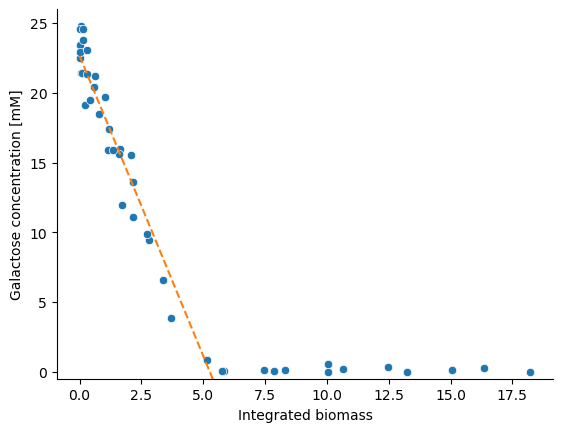

In [8]:
ax = sns.scatterplot(df_galactose, x = 'Integrated biomass', y = 'Galactose concentration [mM]')
fit_idx = (df_galactose['Integrated biomass']<7)&(df_galactose['Galactose concentration [mM]'].notna())
gal_fit = st.linregress(df_galactose.loc[fit_idx, 'Integrated biomass'], df_galactose.loc[fit_idx, 'Galactose concentration [mM]'])
x_arr = np.linspace(0, 7, 10)
y_fit = gal_fit.intercept + gal_fit.slope*x_arr
ax.plot(x_arr, y_fit, ls = '--', c = 'C1')
plt.ylim(-0.5, 26)
sns.despine()
gal_uptake = gal_fit.slope

# Get model and define parameters

In [9]:
model_ez = reframed.load_cbmodel('../../../models/e_coli/momentiJO1366.xml')
model_ez.solver = 'gurobi'

In [10]:
reframed.FBA(model_ez)#, objective={'R_BIOMASS_Ec_iJO1366_WT_53p95M':1})

Set parameter Username
Set parameter LicenseID to value 2586336
Academic license - for non-commercial use only - expires 2025-11-18


Objective: 0.742975386519784
Status: Optimal

In [11]:
model_ez.reactions.R_EX_glc__D_e.lb = 0

In [12]:
cs_to_exchange = {
    'Galactose': 'R_EX_gal_e',
    'L-malate': 'R_EX_mal__L_e',
    'L-alanine': 'R_EX_ala__L_e'
}
cs_to_uptake = {
    'Galactose': gal_uptake,
    'L-malate': mal_uptake,
    'L-alanine': ala_uptake
}

### Get growth rates

In [13]:
growth_rate_df = pd.read_csv(growth_rate_fn, index_col=0)
mean_gr = growth_rate_df[['Carbon source', 'Growth rate']].groupby('Carbon source').agg(['mean', 'std'])
mean_gr.columns = ['Mean', 'Std']
mean_gr

,Mean,Std
Carbon source,,
Galactose,0.273864,0.016978
L-alanine,0.207638,0.005340
L-malate,0.396022,0.008710


### The model is not able to achieve measured growth rate on galactose because of one enzyme value that seems wrong
- "R_GALKr_TG_forward" is very high.
- The reverse reaction has a much lower values.
- To enable the measured growth rate on galactose I change the enzyme value of this reaction to be the same as the for the reverse reaction. 

In [14]:
reframed.FBA(model_ez)

Objective: None
Status: Infeasible or Unbounded

In [15]:
print(model_ez.reactions['R_GALKr_TG_forward'].to_string())
print(model_ez.reactions['R_GALKr_TG_reverse'].to_string())
new_string = "R_GALKr_TG_forward2: M_atp_c + M_gal_c + 0.00037387562982106 M_prot_pool --> M_adp_c + M_gal1p_c + M_h_c"
model_ez.add_reaction_from_str(new_string)
model_ez.remove_reaction('R_GALKr_TG_forward')
reframed.save_cbmodel(model_ez, '../../../models/e_coli/momentiJO1366_modified.xml')

R_GALKr_TG_forward: M_atp_c + M_gal_c + 0.0161922306874758 M_prot_pool --> M_adp_c + M_gal1p_c + M_h_c
R_GALKr_TG_reverse: M_adp_c + M_gal1p_c + M_h_c + 0.00037387562982106 M_prot_pool --> M_atp_c + M_gal_c


### Read mapping between names used in metabolomics results and BiGG IDs
And list measured metabolites that maps to the metabolic model

In [16]:
mapping_dict = pd.read_csv(mapping_fn, index_col = 0).to_dict()['BiGG ID']

In [17]:
measured_metabolite_ids = [f'M_{m_id}_c' for m_id in mapping_dict.values() if isinstance(m_id, str)]
measured_metabolite_ids_in_model = [x for x in measured_metabolite_ids if model_ez.metabolites.get(x)]

## Now estimate metabolite values (-1*shadow prices)
For the measured metabolites that map to the model

In [18]:

sp_dict = {}
for cs, ex_id in cs_to_exchange.items():
    sp_dict[cs] = leakage.estimate_shadow_prices_reframed(model_ez, constraints={ex_id:(cs_to_uptake[cs], 0)}, delta = 0.01, metabolites=measured_metabolite_ids_in_model)
        

In [19]:
mv_df = pd.DataFrame(sp_dict)*-1

## Metabolite value uncertainty

In [20]:
sp_dict_g = {}
for cs, ex_id in cs_to_exchange.items():
    sp_cs_g_list = []
    uptake_rates = np.linspace(cs_to_uptake[cs]*1.2, cs_to_uptake[cs]*0.8, 5, endpoint=True)
    for g in uptake_rates:
        shadow_prices_g = leakage.estimate_shadow_prices_reframed(model_ez, constraints={ex_id:(g, 0)}, delta = 0.01, metabolites=measured_metabolite_ids_in_model)
        sp_cs_g_list.append(shadow_prices_g)
    sp_cs_g_list.append(sp_dict[cs])
    temp_df = -1*pd.DataFrame(sp_cs_g_list)
    sp_dict_g[cs] = {'min': temp_df.min().to_dict(), 'max': temp_df.max().to_dict()}



## Turnover

In [21]:
turnover_dict = {}
for cs, ex_id in cs_to_exchange.items():
    solution = reframed.pFBA(model_ez, constraints={ex_id:(cs_to_uptake[cs], 0)})
    turnover = solution.get_metabolites_turnover(model_ez)
    turnover_dict[cs] = {m: turnover[m] for m in measured_metabolite_ids_in_model}
    print(cs)
    solution.show_values('BIO')
    # solution.show_values(ex_id)
    solution.show_values('R_EX')
    print("####")

Galactose
R_BIOMASS_Ec_iJO1366_core_53p95M  0.405466
R_EX_ca2_e   -0.00211045
R_EX_cl_e    -0.00211045
R_EX_co2_e    9.17308
R_EX_cobalt2_e -1.01366e-05
R_EX_cu2_e   -0.000287475
R_EX_fe2_e   -0.00651219
R_EX_gal_e   -4.3028
R_EX_h_e      3.72552
R_EX_h2o_e    19.8813
R_EX_k_e     -0.0791441
R_EX_meoh_e   8.10932e-07
R_EX_mg2_e   -0.00351742
R_EX_mn2_e   -0.000280177
R_EX_mobd_e  -5.23051e-05
R_EX_nh4_e   -4.37937
R_EX_ni2_e   -0.000130966
R_EX_o2_e    -8.30785
R_EX_pi_e    -0.391125
R_EX_so4_e   -0.102263
R_EX_zn2_e   -0.000138264
####
L-malate
R_BIOMASS_Ec_iJO1366_core_53p95M  0.550032
R_EX_ac_e     0.320435
R_EX_ca2_e   -0.00286292
R_EX_cl_e    -0.00286292
R_EX_co2_e    38.8828
R_EX_cobalt2_e -1.37508e-05
R_EX_cu2_e   -0.000389973
R_EX_fe2_e   -0.00883406
R_EX_h_e     -25.6765
R_EX_h2o_e    37.8836
R_EX_k_e     -0.107362
R_EX_mal__L_e -15.5254
R_EX_meoh_e   1.10006e-06
R_EX_mg2_e   -0.00477153
R_EX_mn2_e   -0.000380072
R_EX_mobd_e  -7.09541e-05
R_EX_nh4_e   -5.9408
R_EX_ni2_e   -0.0

In [22]:
data = []
min_mv = []
max_mv = []
Nc = []
mass = []
turnover_list = []
bigg_id_list = []
for _, row in df_rate.iterrows():
    cs = row['Carbon source']
    met = row['Metabolite']
    try:
        bigg_id = mapping_dict[met]
    except KeyError:
        bigg_id = np.nan
    
    m_id = f'M_{bigg_id}_c'
    try:
        mv = -sp_dict[cs][m_id]
    except KeyError:
        mv = np.nan
    
    if isinstance(bigg_id, str) and np.isfinite(mv):
        data.append(mv)
        min_mv.append(sp_dict_g[cs]['min'][m_id])
        max_mv.append(sp_dict_g[cs]['max'][m_id])
        m = model_ez.metabolites[m_id]
        element_dict = utils.get_element_dict(m)
        Nc.append(element_dict['C'])
        mass.append(utils.get_mol_weight(m))
        turnover_list.append(turnover_dict[cs][m_id])
        bigg_id_list.append(bigg_id)
        
    else:
        data.append(np.nan)
        Nc.append(np.nan)
        mass.append(np.nan)
        turnover_list.append(np.nan)
        bigg_id_list.append(np.nan)
        min_mv.append(np.nan)
        max_mv.append(np.nan)
df_rate['Metabolite value [gDW/mmol]'] = data
df_rate['N carbons'] = Nc
df_rate['Mol weight [g/mol]'] = mass
df_rate['Turnover [mmol/gDW/h]'] = turnover_list
df_rate['Model ID'] = bigg_id_list
df_rate['MV min'] = min_mv
df_rate['MV max'] = max_mv

In [23]:
df_rate['Species'] = 'E. coli'
df_rate['Dataset'] = 'SINTEF-23'

In [24]:
df_rate.to_csv(folder/'1K_rates_and_values.csv')

In [25]:
df_rate.Metabolite.unique()

array(['1,3-diaminopropane', '2,5-dihydroxybenzoate',
       '2-aminoisobutyrate', '2-hydroxybutyrate',
       '2-hydroxyglutaric acid', '3-(4-hydroxyphenyl)pyruvate',
       '3-hydroxyanthranilate', '3-hydroxybutyrate',
       '3-hydroxyglutaric acid', '3-hydroxyphenylacetate',
       '4-acetamidobutanoate', '4-imidazoleacetate', 'Acetate',
       'Adenosine', "Adenosine 3',5'-cyclic phosphate", 'Adipate',
       'Aicar', 'Alanine', 'Allantoin', 'Alpha-aminoadipate',
       'Alpha-aminobutyrate', 'Alpha-glucose (cl adduct)', 'Anthranilate',
       'Arginine', 'Asparagine', 'Aspartate', 'Beta-alanine',
       'Cdp-ethanolamine', 'Cis-aconitate', 'Citrate', 'Citrulline',
       'Creatine', 'Creatinine', 'Cyclic gmp',
       'Deoxycarnitine (deoxy-c0)', 'Dethiobiotin', 'Diaminopimelate',
       'Diethanolamine', 'Dihydroorotate', 'Dihydrouracil',
       'Ethanolamine', 'Formate', 'Fructose-6-phosphate',
       'Gamma-aminobutyrate', 'Gluconate', 'Gluconolactone', 'Glutamate',
       'Glu

In [26]:
df_rate.loc[df_rate['Rate [mmol/gDW/h]'].notna()&df_rate['Metabolite value [gDW/mmol]'].isna()]


,Carbon source,Metabolite,Slope,Intercept,r,p-value,Std. Err,N,T3_pval,Fitted on,...,Std. Err [1/gDW/h],Metabolite value [gDW/mmol],N carbons,Mol weight [g/mol],Turnover [mmol/gDW/h],Model ID,MV min,MV max,Species,Dataset
57,Galactose,Alpha-aminoadipate,0.028487,-0.048125,0.773682,0.226318,0.016496,4,0.850027,Concentration [uM],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E. coli,SINTEF-23
58,L-malate,Alpha-aminoadipate,0.042200,-0.023608,0.514331,0.375277,0.040625,5,0.876675,Concentration [uM],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E. coli,SINTEF-23
59,L-alanine,Alpha-aminoadipate,0.739923,-0.930391,0.717262,0.029618,0.271687,9,0.579479,Z-score,...,0.271687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E. coli,SINTEF-23
62,L-alanine,Alpha-aminobutyrate,187.598140,52.171940,0.945407,0.000003,20.449561,12,0.986340,Concentration [uM],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E. coli,SINTEF-23
93,Galactose,Creatine,0.001029,0.001165,0.688105,0.013371,0.000343,12,0.812894,Concentration [uM],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E. coli,SINTEF-23
94,L-malate,Creatine,-0.000225,0.002495,-0.164844,0.628129,0.000449,11,0.005142,Concentration [uM],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E. coli,SINTEF-23
95,L-alanine,Creatine,-0.003381,0.016647,-0.603979,0.037545,0.001411,12,0.294103,Concentration [uM],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E. coli,SINTEF-23
102,Galactose,Deoxycarnitine (deoxy-c0),0.296919,0.220566,0.840071,0.009039,0.078276,8,0.951307,Concentration [uM],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E. coli,SINTEF-23
103,L-malate,Deoxycarnitine (deoxy-c0),0.901709,-0.381443,0.846833,0.033394,0.283162,6,0.904506,Concentration [uM],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E. coli,SINTEF-23
104,L-alanine,Deoxycarnitine (deoxy-c0),-0.113538,0.633089,-0.477085,0.338667,0.104576,6,0.663927,Concentration [uM],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E. coli,SINTEF-23


In [35]:
df_rate.loc[df_rate['Rate [mmol/gDW/h]'].notna(), ['Metabolite', 'Metabolite value [gDW/mmol]']].tail(50)

,Metabolite,Metabolite value [gDW/mmol]
171,Hexoses,NaN
189,Isocitrate,0.064213
190,Isocitrate,0.014926
191,Isocitrate,0.052369
192,Isoleucine,0.122042
193,Isoleucine,0.088451
194,Isoleucine,0.090761
201,Lactate,0.037631
202,Lactate,0.009375
203,Lactate,0.027255
